In [1]:
import numpy as np
import cupy as cp
import sys
import pandas as pd
import time
import matplotlib.pyplot as plt
import h5py
from types import SimpleNamespace
import warnings
warnings.filterwarnings("ignore", message=f".*peer.*")


sys.path.insert(0, '..')
from utils import *
from rec import Rec

# find shift with 1 pixel accuracy

In [2]:
with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924_h5/AtomiumS2/AtomiumS2_codedht_random_007nm/data_corrected.h5') as fid:
    sx0 = fid['/exchange/sx0'][0]    
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]    
    focusToDetectorDistance = fid['/exchange/focusdetectordistance'][0]    
    z10 = fid['/exchange/z1'][0]    
    theta = fid['/exchange/theta'][:]
    shifts_cor = fid['/exchange/shifts_cor'][:]
    shifts_code = fid['/exchange/shifts_code'][:]    

In [3]:
z1c = -17.75e-3
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
z1 = z10 - sx0
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications)
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)#magnifications2

show = True

In [4]:
args = SimpleNamespace()
args.npos = 1
args.ngpus = 4
args.lam = 0.1

args.n = 2048
voxelsize *= 2048/args.n
args.ntheta = 7200
args.theta = theta[::len(theta)//args.ntheta]/180*np.pi
args.ncode = 8704*args.n//2048
args.pad = args.n // 8
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 8
args.npatch = args.nq + 2 * args.ex
args.nchunk = 4

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.eps = 1e-12
args.rho = [1, 0.5, 0.1]
args.crop = 0#2 * args.pad
args.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec0224//AtomiumS2/AtomiumS2_codedht_random_007nm//{args.lam}_{args.rho[1]}_{args.rho[2]}"


args.niter = 1
args.err_step = 1
args.vis_step = 1
args.method = "BH-CG"
args.show = True
args.rotation_axis = 157*args.n/256#args.npsi/2
# create class
cl_rec = Rec(args)


In [5]:
ri = np.round(shifts_code).astype('int32')
r = (shifts_code-ri).astype('float32')

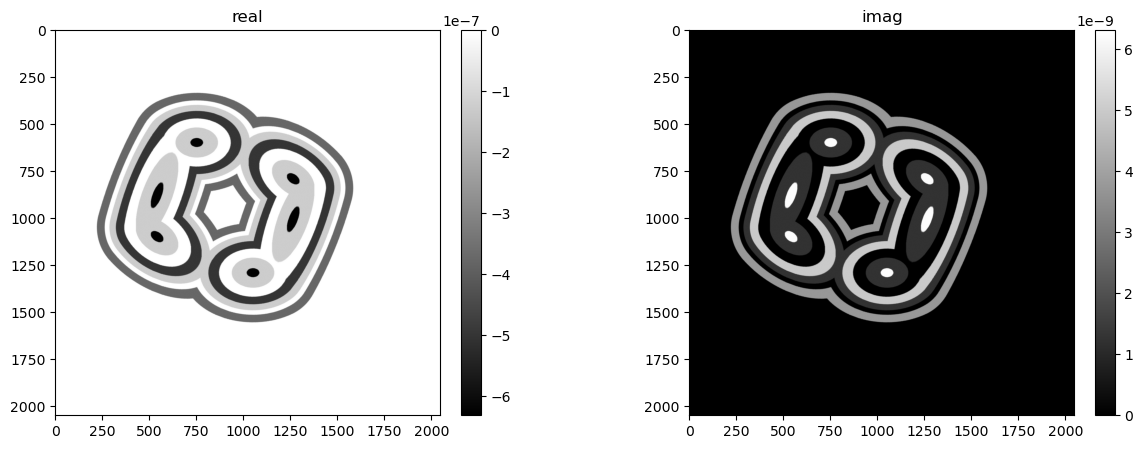

In [6]:
u0= np.load(f'/data/vnikitin/syn_3d_ald/u{args.n}.npy').astype('complex64')/4
mshow_complex(u0[u0.shape[0]//2],show)

In [7]:
# import scipy.ndimage as ndimage
# print(args.pad)

# u = ndimage.zoom(u0,1.5,order=1)
# u = u[u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2,
#       u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2,
#       u.shape[0]//2-args.npsi//2:u.shape[0]//2+args.npsi//2]
# # u = np.zeros([args.n,args.n,args.n],dtype='complex64')

In [8]:
ppad = args.npsi//2-args.n//2
u = np.pad(u0,((ppad,ppad),(ppad,ppad),(ppad,ppad)),'edge')

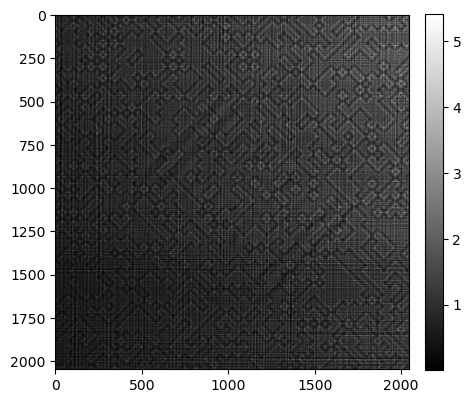

In [9]:
path_out = '/data/vnikitin/ESRF/ID16A/20240924_h5/AtomiumS2/AtomiumS2_codedht_random_007nm/'
with  h5py.File(f'{path_out}/data_corrected.h5','r') as fid:    
    q = fid['/exchange/prb'][:]
    code = fid['/exchange/code'][:]   
    cdata = fid['/exchange/cdata'][:]
    cdata2 = fid['/exchange/cdata2'][::7200//args.ntheta] 
    ref = fid['/exchange/ref'][:]
    shifts_cor = fid['/exchange/shifts_cor'][::7200//args.ntheta]
    shifts_code = fid['/exchange/shifts_code'][::7200//args.ntheta]
    data = fid['/exchange/data'][::7200//args.ntheta]
    
rpsi = shifts_cor
c =  args.voxelsize * 2*cp.pi / args.wavelength#*np.sqrt(args.npsi*args.ntheta)
u_new = (u*c).astype('complex64')
data = np.abs(cl_rec.fwd(ri,r,rpsi,code,u_new,q))**2

mshow(data[-1],True)

In [10]:

path_out = '/data/vnikitin/ESRF/ID16A/20240924_h5_syn/AtomiumS2/AtomiumS2_codedht_random_007nm/'

with  h5py.File(f'{path_out}/data_corrected.h5','w') as fid:
    fid.create_dataset('/exchange/cdata2',data=cdata2)
    fid.create_dataset('/exchange/cdata',data=cdata)
    fid.create_dataset('/exchange/ref',data=ref)
    fid.create_dataset('/exchange/prb',data=q)
    fid.create_dataset('/exchange/code',data=code)
    fid.create_dataset('/exchange/shifts_cor',data=shifts_cor)
    fid.create_dataset('/exchange/shifts_code',data=shifts_code)
    dvoxelsize = fid.create_dataset('/exchange/voxelsize',shape=(1,),dtype='float32')
    dvoxelsize[0]=voxelsize
    dsx0 = fid.create_dataset('/exchange/sx0',shape=(1,),dtype='float32')
    dsx0[0] = sx0
    dz1 = fid.create_dataset('/exchange/z1',shape=(1,),dtype='float32')
    dz1[0]=z10
    ddetector_pixelsize = fid.create_dataset('/exchange/detector_pixelsize',shape=(1,),dtype='float32')
    ddetector_pixelsize[0]=detector_pixelsize
    dfocusdetectordistance = fid.create_dataset('/exchange/focusdetectordistance',shape=(1,),dtype='float32')
    dfocusdetectordistance[0]=focusToDetectorDistance
    fid.create_dataset('/exchange/data',data=data)    
    fid.create_dataset('/exchange/theta',data=theta)




: 